In [24]:
from typing import List
from copy import deepcopy

import collections
import matplotlib.pyplot as plt; plt.rcParams.update({"font.family": "serif"})

import pyscf
import pyscf.cc
import pyscf.mcscf

# To get molecular geometries.
import openfermion as of
from openfermion import MolecularData
from openfermionpyscf import run_pyscf

import qiskit
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.primitives import BitArray
from qiskit_aer import AerSimulator  # For MPS Simulator.

import ffsim

# To run on hardware.
import qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler

from functools import partial

import numpy as np

from qiskit_addon_sqd.fermion import SCIResult, diagonalize_fermionic_hamiltonian, solve_sci_batch

from adaptvqe.pools import DVG_CEO
from adaptvqe.algorithms.adapt_vqe import LinAlgAdapt, TensorNetAdapt

In [2]:
ibm_computer: str = "ibm_fez"

service = qiskit_ibm_runtime.QiskitRuntimeService(channel="local")
computer = service.backend()
sampler = Sampler(computer)

/Users/benjamindalfavero/.venv/adapt/lib/python3.13/site-packages/qiskit_ibm_runtime/fake_provider/backends/nighthawk/fake_nighthawk.py:76: UserWarning: Properties of fake_nighthawk are not intended to represent typical nighthawk error values.
  warnings.warn(


In [3]:
mol = pyscf.gto.Mole()
geom = of.chem.geometry_from_pubchem("BeH2")
basis = "sto-3g"
symmetry = "Cs"
multiplicity = 1
charge = 0
mol.build(
    atom=geom,
    basis=basis,
    symmetry=symmetry,
)

In [4]:
n_frozen = 0
active_space = range(n_frozen, mol.nao_nr())

In [5]:
# Get molecular integrals
scf = pyscf.scf.RHF(mol).run()
num_orbitals = len(active_space)
n_electrons = int(sum(scf.mo_occ[active_space]))
num_elec_a = (n_electrons + mol.spin) // 2
num_elec_b = (n_electrons - mol.spin) // 2
cas = pyscf.mcscf.CASCI(scf, num_orbitals, (num_elec_a, num_elec_b))
mo = cas.sort_mo(active_space, base=0)
hcore, nuclear_repulsion_energy = cas.get_h1cas(mo)
eri = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), num_orbitals)

# Compute exact energy
exact_energy = cas.run().e_tot

converged SCF energy = -14.4432411484893
CASCI E = -14.4729474150150  E(CI) = -21.7936666741835  S^2 = 0.0000000


In [6]:
exact_energy

np.float64(-14.472947415015046)

## Get the Ansatz circuit

In [7]:
mol_of = MolecularData(geom, basis, multiplicity, charge, description='H2')
mol_of = run_pyscf(mol_of, run_fci=True, run_ccsd=True)
nelec = (num_elec_a, num_elec_b)
print(mol_of.n_orbitals)
print(mol_of.hf_energy)

7
-14.443241148489246


In [8]:
pool = DVG_CEO(mol_of)

max_mpo_bond = 200
adapt_mps_bond = 10
my_adapt = TensorNetAdapt(
    pool=pool,
    molecule=mol_of,
    max_adapt_iter=1,
    recycle_hessian=True,
    tetris=True,
    verbose=True,
    threshold=0.1,
    max_mpo_bond=max_mpo_bond,
    max_mps_bond=adapt_mps_bond
)

my_adapt.initialize()

circuits = []
adapt_energies = []
for i in range(6):
    print(f"On iteration {i}.")
    my_adapt.run_iteration()
    data = my_adapt.data
    ansatz_circuit = pool.get_circuit(my_adapt.indices, my_adapt.coefficients)
    print("coefficients:", my_adapt.coefficients)
    print("indices:", my_adapt.indices)
    # Prepare the HF reference state, then add the Ansatz circuit.
    q = QuantumRegister(2 * num_orbitals)
    circuit = QuantumCircuit(q)
    circuit.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), q)
    circuit = circuit.compose(ansatz_circuit)
    circuit.measure_all()
    circuits.append(circuit)
    adapt_energies.append(my_adapt.energy)


tensor-net-adapt prepared with the following settings:
> Pool: DVG_CEO
> Molecule: H2 (interatomic distance r=0Å)
> Orbital Optimization: False
> Selection method: gradient
> Convergence criterion: total_g_norm
> Recycling Hessian: True
> Tetris: True (progressive optimization: False)
> Convergence threshold (gradient norm):  0.1
> Maximum number of iterations:  1
> candidates per iteration:  1

Initial energy: -14.4432414573326
On iteration 0.

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 2436 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 2: -2.3853360207062194e-08
Operator 4: 1.7299256416152932e-08
Operator 5: -7.68565906713296e-06
Operator 8: -1.1044822125412236e-08
Operator 10: -2.472749303300001e-08
Operator 11: 3.992637975505275e-06
Operator 13: 2.2665318644162164e-07
Operator 15: 6.945120319784596e-08
Operator 16: 1.3485778894956969e-05
Operator 18: -2.4599685241209357e-07
Operator 20: -6.176404702414818e-08
Operator 21: -2.27

/Users/benjamindalfavero/.venv/adapt/lib/python3.13/site-packages/quimb/tensor/circuit.py:215: SyntaxWarning: Unsupported operation ignored: barrier
  warnings.warn(
/Users/benjamindalfavero/.venv/adapt/lib/python3.13/site-packages/quimb/tensor/circuit.py:215: SyntaxWarning: Unsupported operation ignored: barrier
  warnings.warn(


Optimization terminated successfully.
         Current function value: -14.443241
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1

Current energy: -14.443241457332489
(change of 1.1191048088221578e-13)
Current ansatz: [np.int64(2206), np.int64(1848), np.int64(1174)]
coefficients: [np.float64(0.0), np.float64(0.0), np.float64(0.0)]
indices: [2206 1848 1174]
On iteration 1.

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 2436 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 2: -2.3853360205903748e-08
Operator 4: 1.729925637689344e-08
Operator 5: -7.685659067132919e-06
Operator 8: -1.1044822131060346e-08
Operator 10: -2.472749308110954e-08
Operator 11: 3.992637975505254e-06
Operator 13: 2.2665318658215658e-07
Operator 15: 6.945120310264343e-08
Operator 16: 1.3485778894956793e-05
Operator 18: -2.459968524313828e-07
Operator 20: -6.176404728519402e-08
Operator 21: -2.2742207153425957e-05
Operator 22: 8.4

/Users/benjamindalfavero/.venv/adapt/lib/python3.13/site-packages/quimb/tensor/circuit.py:215: SyntaxWarning: Unsupported operation ignored: barrier
  warnings.warn(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/.venv/adapt/lib/python3.13/site-packages/quimb/tensor/circuit.py:215: SyntaxWarning: Unsupported operation ignored: barrier
  warnings.warn(


         Current function value: -14.443241
         Iterations: 0
         Function evaluations: 34
         Gradient evaluations: 22

Current energy: -14.443241457332599
(change of -1.1013412404281553e-13)
Current ansatz: [np.int64(2206), np.int64(1848), np.int64(1174), np.int64(2206), np.int64(1848), np.int64(1174)]
coefficients: [np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0)]
indices: [2206 1848 1174 2206 1848 1174]
On iteration 2.

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 2436 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 2: -2.3853360202071192e-08
Operator 4: 1.729925641425975e-08
Operator 5: -7.685659067132975e-06
Operator 8: -1.10448221214104e-08
Operator 10: -2.4727493029313946e-08
Operator 11: 3.992637975505277e-06
Operator 13: 2.2665318655266104e-07
Operator 15: 6.945120315574608e-08
Operator 16: 1.3485778894956844e-05
Operator 18: -2.459968524047882e-07
Operator 20

/Users/benjamindalfavero/.venv/adapt/lib/python3.13/site-packages/quimb/tensor/circuit.py:215: SyntaxWarning: Unsupported operation ignored: barrier
  warnings.warn(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/.venv/adapt/lib/python3.13/site-packages/quimb/tensor/circuit.py:215: SyntaxWarning: Unsupported operation ignored: barrier
  warnings.warn(


         Current function value: -14.449671
         Iterations: 2
         Function evaluations: 52
         Gradient evaluations: 40

Current energy: -14.449670978433595
(change of -0.0064295211010012565)
Current ansatz: [np.int64(2206), np.int64(1848), np.int64(1174), np.int64(2206), np.int64(1848), np.int64(1174), np.int64(2206), np.int64(1848), np.int64(1174), np.int64(2206), np.int64(1848), np.int64(1174)]
coefficients: [np.float64(-0.008770486908116479), np.float64(-0.008491746329644601), np.float64(-0.00028282254241440236), np.float64(-0.00780328101090085), np.float64(-0.008495132567003183), np.float64(-0.0002830353020394162), np.float64(-0.007803342236970052), np.float64(-0.008505874450017836), np.float64(-0.0002831205695093548), np.float64(-0.007803313724677272), np.float64(-0.008527767899809666), np.float64(-0.00028326008765875793)]
indices: [2206 1848 1174 2206 1848 1174 2206 1848 1174 2206 1848 1174]
On iteration 4.

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 24

/Users/benjamindalfavero/.venv/adapt/lib/python3.13/site-packages/quimb/tensor/circuit.py:215: SyntaxWarning: Unsupported operation ignored: barrier
  warnings.warn(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/.venv/adapt/lib/python3.13/site-packages/quimb/tensor/circuit.py:215: SyntaxWarning: Unsupported operation ignored: barrier
  warnings.warn(


         Current function value: -14.449671
         Iterations: 0
         Function evaluations: 102
         Gradient evaluations: 90

Current energy: -14.449670978434252
(change of -2.3803181647963356e-13)
Current ansatz: [np.int64(2206), np.int64(1848), np.int64(1174), np.int64(2206), np.int64(1848), np.int64(1174), np.int64(2206), np.int64(1848), np.int64(1174), np.int64(2206), np.int64(1848), np.int64(1174), np.int64(2200), np.int64(1838), np.int64(1174), np.int64(2200), np.int64(1838), np.int64(1174)]
coefficients: [np.float64(-0.008770486908116479), np.float64(-0.008491746329644601), np.float64(-0.00028282254241440236), np.float64(-0.00780328101090085), np.float64(-0.008495132567003183), np.float64(-0.0002830353020394162), np.float64(-0.007803342236970052), np.float64(-0.008505874450017836), np.float64(-0.0002831205695093548), np.float64(-0.007803313724677272), np.float64(-0.008527767899809666), np.float64(-0.00028326008765875793), np.float64(0.0), np.float64(0.0), np.float64(0

In [9]:
circuit = circuits[-1]
print(circuit)

         ┌───────────────────┐┌───┐┌───┐                           »
   q5_0: ┤0                  ├┤ X ├┤ H ├───────────────────────────»
         │                   │└─┬─┘├───┤┌───┐                 ┌───┐»
   q5_1: ┤1                  ├──┼──┤ X ├┤ H ├─────────────────┤ X ├»
         │                   │  │  └─┬─┘└───┘                 └─┬─┘»
   q5_2: ┤2                  ├──┼────┼──────────────────────────┼──»
         │                   │  │    │                          │  »
   q5_3: ┤3                  ├──┼────┼──────────────────────────┼──»
         │                   │  │    │                          │  »
   q5_4: ┤4                  ├──┼────┼──────────────────────────┼──»
         │                   │  │    │                          │  »
   q5_5: ┤5                  ├──┼────┼──────────────────────────┼──»
         │                   │  │    │                          │  »
   q5_6: ┤6                  ├──┼────┼──────────────────────────┼──»
         │   Hartree_fock_jw │  │ 

In [10]:
nq = circuit.num_qubits
print(f"Circuit has {nq} qubits.")

Circuit has 14 qubits.


In [11]:
for circuit in circuits:
    print(circuit.depth())

41
80
119
158
197
236


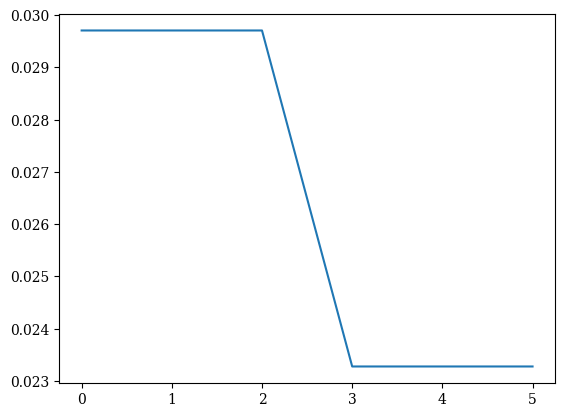

In [12]:
fig, ax = plt.subplots()
ax.plot(abs(np.array(adapt_energies) - exact_energy))

## Sample shots from the circuit

In [13]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

spin_a_layout = list(range(0, 12))
spin_b_layout = [12, 13, 14, 15, 19, 35, 34, 33, 32, 31, 30, 29]
initial_layout = spin_a_layout + spin_b_layout

pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=computer, initial_layout=initial_layout[:nq]
)

# without PRE_INIT passes
isa_circuit = pass_manager.run(circuit)
print(f"Gate counts (w/o pre-init passes): {isa_circuit.count_ops()}")

# with PRE_INIT passes
# We will use the circuit generated by this pass manager for hardware execution
pass_manager.pre_init = ffsim.qiskit.PRE_INIT
to_run = pass_manager.run(circuit)
print(f"Gate counts (w/ pre-init passes): {to_run.count_ops()}")

Gate counts (w/o pre-init passes): OrderedDict({'cx': 226, 'rz': 221, 'sx': 156, 'barrier': 19, 'measure': 14, 'x': 6})
Gate counts (w/ pre-init passes): OrderedDict({'cx': 228, 'rz': 217, 'sx': 153, 'barrier': 19, 'measure': 14, 'x': 6})


In [14]:
# Get the HF state for visualizing results.
q = QuantumRegister(2 * num_orbitals)
hf = QuantumCircuit(q)
hf.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), q)
hf.measure_all()
hf = pass_manager.run(hf)

simulator = AerSimulator(method="matrix_product_state")
result = simulator.run(hf, shots=1)
hf_bitstring = list(result.result().get_counts().keys())[0]
hf_bitstring

'00001110000111'

# Get counts

In [15]:
job = sampler.run([to_run], shots=30_000)

In [16]:
bit_array = job.result()[0].data.meas

In [17]:
print(type(bit_array))

<class 'qiskit.primitives.containers.bit_array.BitArray'>


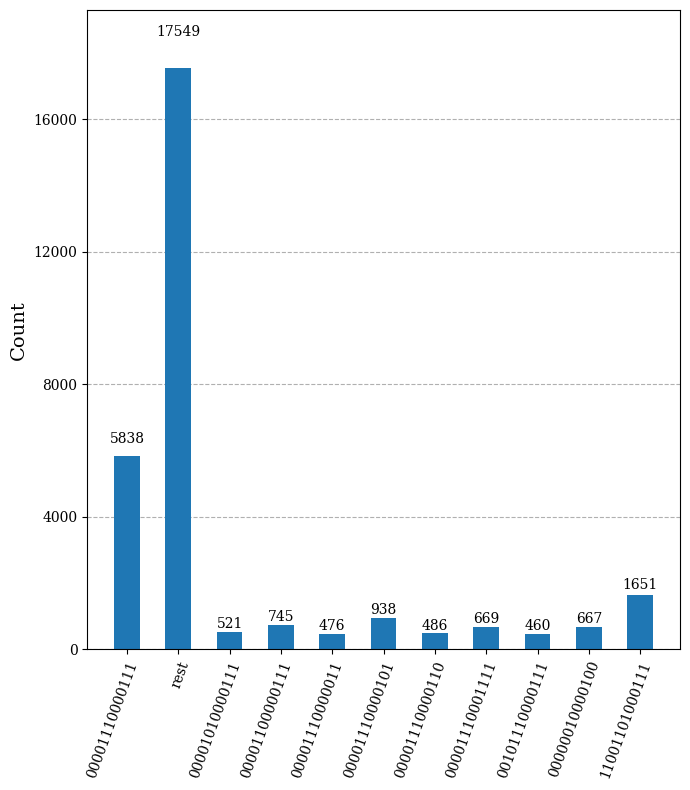

In [18]:
qiskit.visualization.plot_histogram(
    bit_array.get_counts(),
    target_string=hf_bitstring,
    sort="hamming",
    number_to_keep=10,
    figsize=(7, 8),
    # ax=ax
    # filename="hf_ucj2.pdf",
)
# plt.tight_layout()
# plt.savefig("hf_ucj1.pdf")

## Post-process result.

In [19]:
bit_arrays = []
for circuit in circuits:
    job = sampler.run([to_run], shots=30_000)
    bit_array = job.result()[0].data.meas
    bit_arrays.append(deepcopy(bit_array))

In [20]:
energies = []
errors = []

for bit_array in bit_arrays:
    # SQD options
    energy_tol = 1e-5
    occupancies_tol = 1e-6
    max_iterations = 20
    rng = np.random.default_rng(1)

    # Eigenstate solver options
    num_batches = 2
    samples_per_batch = 1000
    symmetrize_spin = True
    carryover_threshold = 1e-4
    max_cycle = 200

    # Pass options to the built-in eigensolver. If you just want to use the defaults,
    # you can omit this step, in which case you would not specify the sci_solver argument
    # in the call to diagonalize_fermionic_hamiltonian below.
    sci_solver = partial(solve_sci_batch, spin_sq=0.0, max_cycle=max_cycle)

    # List to capture intermediate results
    result_history = []


    def callback(results: list[SCIResult]):
        result_history.append(results)
        iteration = len(result_history)
        print(f"Iteration {iteration}")
        for i, result in enumerate(results):
            print(f"\tSubsample {i}")
            print(f"\t\tEnergy: {result.energy + nuclear_repulsion_energy}")
            print(f"\t\tSubspace dimension: {np.prod(result.sci_state.amplitudes.shape)}")


    result = diagonalize_fermionic_hamiltonian(
        hcore,
        eri,
        bit_array,
        samples_per_batch=samples_per_batch,
        norb=num_orbitals,
        nelec=nelec,
        num_batches=num_batches,
        energy_tol=energy_tol,
        occupancies_tol=occupancies_tol,
        max_iterations=max_iterations,
        sci_solver=sci_solver,
        symmetrize_spin=symmetrize_spin,
        carryover_threshold=carryover_threshold,
        callback=callback,
        seed=rng,
    )

    min_e = [
        min(result, key=lambda res: res.energy).energy + nuclear_repulsion_energy
        for result in result_history
    ]
    approx_energy = min(min_e)
    err = abs(min(min_e) - exact_energy)
    print(approx_energy, err)
    energies.append(approx_energy)
    errors.append(err)

Iteration 1
	Subsample 0
		Energy: -14.472827822136477
		Subspace dimension: 961
	Subsample 1
		Energy: -14.472827822136477
		Subspace dimension: 961
Iteration 2
	Subsample 0
		Energy: -14.472947415581732
		Subspace dimension: 1225
	Subsample 1
		Energy: -14.472947415581732
		Subspace dimension: 1225
Iteration 3
	Subsample 0
		Energy: -14.472947415581732
		Subspace dimension: 1225
	Subsample 1
		Energy: -14.472947415581732
		Subspace dimension: 1225
-14.472947415581732 5.666862534781103e-10
Iteration 1
	Subsample 0
		Energy: -14.472947415581732
		Subspace dimension: 1225
	Subsample 1
		Energy: -14.472947415581732
		Subspace dimension: 1225
Iteration 2
	Subsample 0
		Energy: -14.472947415581732
		Subspace dimension: 1225
	Subsample 1
		Energy: -14.472947415581732
		Subspace dimension: 1225
-14.472947415581732 5.666862534781103e-10
Iteration 1
	Subsample 0
		Energy: -14.472947415581732
		Subspace dimension: 1225
	Subsample 1
		Energy: -14.472947415581732
		Subspace dimension: 1225
Iterat

In [21]:
print(energies)
print(errors)

[np.float64(-14.472947415581732), np.float64(-14.472947415581732), np.float64(-14.472947415581732), np.float64(-14.472947415581732), np.float64(-14.472947415581732), np.float64(-14.472947415581732)]
[np.float64(5.666862534781103e-10), np.float64(5.666862534781103e-10), np.float64(5.666862534781103e-10), np.float64(5.666862534781103e-10), np.float64(5.666862534781103e-10), np.float64(5.666862534781103e-10)]


## Concatenate multiple rounds

Suppose we get bit arrays $B_1, B_2, \ldots, B_n$ from $n$ rounds of ADAPT. Run the SQD with the sequence of bit arrays $[B_1], [B_1, B_2], \ldots, [B_1, B_2, \ldots, B_n]$, where $[\cdot]$ denotes vertically concatenating arrays.